--- Starting Data Loading ---
Original Datasets loaded successfully for target variable creation and feature engineering!
Train data shape: (132379, 14)
Test data shape: (33095, 14)

--- Creating Target Variables for Training Data ---
Target Variables Created and Added to Training Data!
Unique session IDs in train_df_with_targets: 22910
Number of purchase sessions (Is_Purchase=1): 1411

--- Starting Feature Engineering (Session & Time-based Metrics) ---
Combined DataFrame for FE shape: (165474, 14)
Columns in combined_df_for_fe: ['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']
session_agg shape: (24026, 11)
session_level_features_modes shape: (24026, 11)
session_level_features (after merge) shape: (24026, 21)
Feature Engineering Complete. Session-level features created.
encoded_train_features shape before target alignment: (22910, 20)
encoded_test_features sha

c:\Users\sathy\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:20:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier tuning and training complete.

Training XGBoost Regressor...
Before GridSearchCV fit for regression:
  Shape of X_train_reg_filtered: (1127, 93), Type: <class 'pandas.core.frame.DataFrame'>
  Shape of y_train_reg_filtered: (1127,), Type: <class 'numpy.ndarray'>
XGBoost Regressor tuning and training complete.

--- Model Training and Tuning Complete ---

--- Step 6: Comprehensive Model Evaluation ---

--- Final Evaluation for Tuned XGBoost Classifier ---
Best Classification Model: XGBoost Classifier (Tuned)
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Cross-Validated ROC-AUC Score: 0.9995
--- Metrics on Validation Set ---
Accuracy: 0.9897
Precision: 0.8660
Recall: 0.9858
F1-Score: 0.9221
ROC-AUC Score: 0.9953


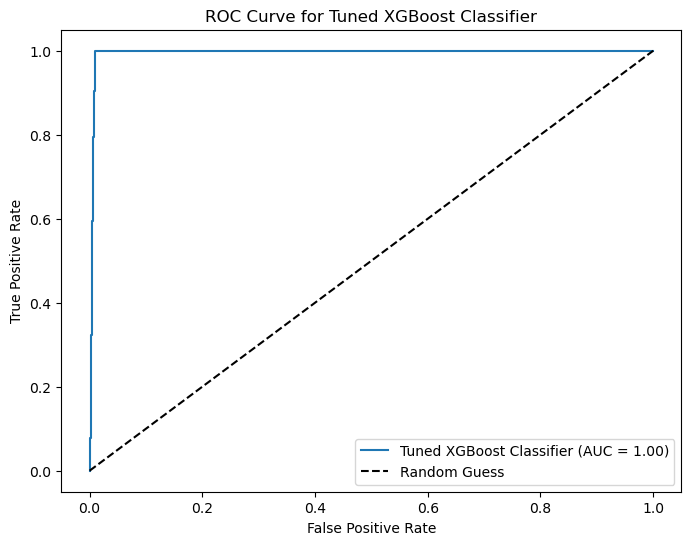


--- Final Evaluation for Tuned XGBoost Regressor ---
Best Regression Model: XGBoost Regressor (Tuned)
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Cross-Validated RMSE: 84.7958
--- Metrics on Filtered Validation Set (Purchases Only) ---
Mean Absolute Error (MAE): 64.62
Mean Squared Error (MSE): 30642.66
Root Mean Squared Error (RMSE): 175.05
R-squared (R2): 0.9333


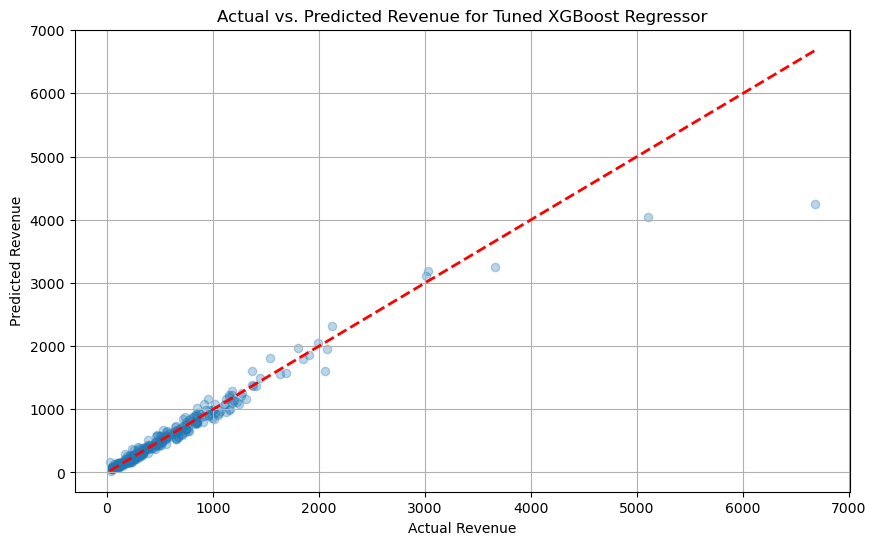


--- Model Evaluation Complete ---

--- Step 6.3: Customer Segmentation (Clustering) ---

--- Elbow Method to determine optimal number of clusters ---


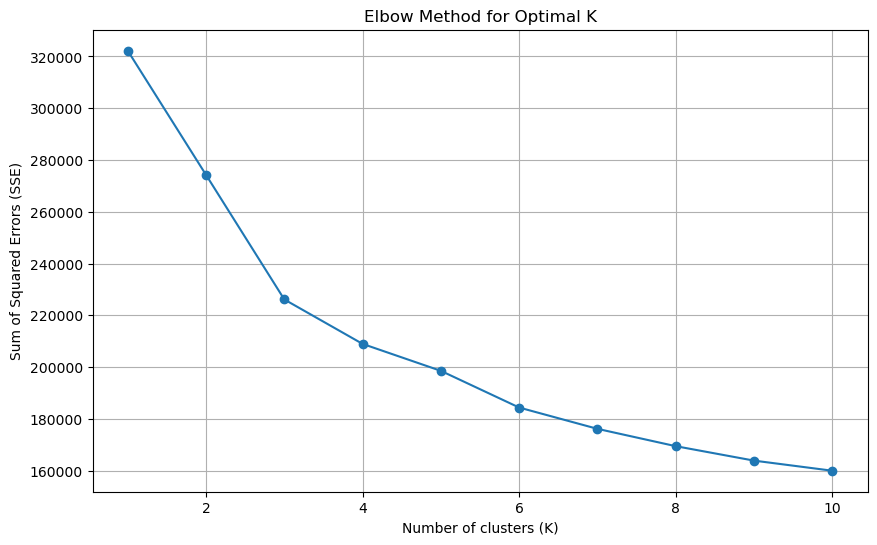

Please examine the Elbow Method plot above to choose the optimal K.

Applying K-Means with K = 3

--- Clustering Metrics ---
Silhouette Score: 0.1749
Davies-Bouldin Index: 1.7555

--- Clustering Complete ---

--- Final Model Selection and Prediction on Test Data ---

--- Making predictions on the TEST data ---

--- Predictions on test data complete! ---
Head of the test predictions DataFrame:
   session_id  Is_Purchase_Predicted  Purchase_Probability  \
0           1                      1              0.922962   
1           2                      0              0.000103   
2           3                      0              0.032568   
3           6                      0              0.000017   
4           7                      0              0.000025   

   Revenue_Generated_Predicted  
0                   313.799988  
1                     0.000000  
2                     0.000000  
3                     0.000000  
4                     0.000000  

--- Saving predictions to CSV --

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib # Import joblib for saving models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
import os # Import os for path checking

# Classification model imports
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Regression model imports
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Clustering imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


# --- Load the datasets ---
print("--- Starting Data Loading ---")
try:
    if not os.path.exists('train_data.csv'):
        raise FileNotFoundError("train_data.csv not found.")
    if not os.path.exists('test_data.csv'):
        raise FileNotFoundError("test_data.csv not found.")

    train_df_original = pd.read_csv('train_data.csv')
    test_df_original = pd.read_csv('test_data.csv')
    print("Original Datasets loaded successfully for target variable creation and feature engineering!")
    print(f"Train data shape: {train_df_original.shape}")
    print(f"Test data shape: {test_df_original.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure 'train_data.csv' and 'test_data.csv' are in the same directory as your script.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    exit()


# --- Step 2.0: Create Target Variables (Classification & Regression) ---
print("\n--- Creating Target Variables for Training Data ---")

temp_train_df = train_df_original.copy()

# Classification Target: Is_Purchase (page 5 indicates purchase)
temp_train_df['temp_Is_Purchase'] = temp_train_df['page'].apply(lambda x: 1 if x == 5 else 0)
purchase_sessions = temp_train_df.groupby('session_id')['temp_Is_Purchase'].max().reset_index()
purchase_sessions.rename(columns={'temp_Is_Purchase': 'Is_Purchase'}, inplace=True)
temp_train_df = pd.merge(temp_train_df, purchase_sessions, on='session_id', how='left')

# Regression Target: Revenue_Generated (sum of price for purchase sessions)
session_revenue = temp_train_df.groupby('session_id')['price'].sum().reset_index()
session_revenue.rename(columns={'price': 'Total_Session_Price'}, inplace=True)
temp_train_df = pd.merge(temp_train_df, session_revenue, on='session_id', how='left')
temp_train_df['Revenue_Generated'] = temp_train_df.apply(lambda row: row['Total_Session_Price'] if row['Is_Purchase'] == 1 else 0, axis=1)

temp_train_df.drop(columns=['temp_Is_Purchase', 'Total_Session_Price'], inplace=True)
train_df_with_targets = temp_train_df.copy()

print("Target Variables Created and Added to Training Data!")
print(f"Unique session IDs in train_df_with_targets: {train_df_with_targets['session_id'].nunique()}")
print(f"Number of purchase sessions (Is_Purchase=1): {purchase_sessions['Is_Purchase'].sum()}")


# --- Step 3: Feature Engineering ---
print("\n--- Starting Feature Engineering (Session & Time-based Metrics) ---")

combined_df_for_fe = pd.concat([train_df_with_targets.drop(columns=['Is_Purchase', 'Revenue_Generated']), test_df_original], ignore_index=True)
print(f"Combined DataFrame for FE shape: {combined_df_for_fe.shape}")
print(f"Columns in combined_df_for_fe: {combined_df_for_fe.columns.tolist()}")

session_agg = combined_df_for_fe.groupby('session_id').agg(
    session_length=('order', 'count'),
    max_order=('order', 'max'),
    min_order=('order', 'min'),
    avg_price_per_session=('price', 'mean'),
    max_price_per_session=('price', 'max'),
    min_price_per_session=('price', 'min'),
    num_unique_page1_categories=('page1_main_category', lambda x: x.nunique()),
    num_unique_countries=('country', lambda x: x.nunique()),
    max_page_visited=('page', 'max'),
    min_page_visited=('page', 'min')
).reset_index()
print(f"session_agg shape: {session_agg.shape}")

session_level_features_modes = combined_df_for_fe.groupby('session_id').agg(
    year=('year', 'first'),
    month=('month', lambda x: x.mode()[0] if not x.mode().empty else 1),
    day=('day', lambda x: x.mode()[0] if not x.mode().empty else 1),
    country=('country', lambda x: x.mode()[0] if not x.mode().empty else 'Others'),
    page1_main_category=('page1_main_category', lambda x: x.mode()[0] if not x.mode().empty else 'Others'),
    colour=('colour', lambda x: x.mode()[0] if not x.mode().empty else 'Others'),
    location=('location', lambda x: x.mode()[0] if not x.mode().empty else 'Others'),
    model_photography=('model_photography', lambda x: x.mode()[0] if not x.mode().empty else 'No'),
    price_avg_click=('price', 'mean'), # Using mean of price for 'price_avg_click'
    price2_mode=('price_2', lambda x: x.mode()[0] if not x.mode().empty else 0.0), # price2_mode is numerical
).reset_index()
print(f"session_level_features_modes shape: {session_level_features_modes.shape}")

session_level_features = pd.merge(session_level_features_modes, session_agg, on='session_id', how='left')
print(f"session_level_features (after merge) shape: {session_level_features.shape}")

session_level_features['date'] = pd.to_datetime(session_level_features[['year', 'month', 'day']])
session_level_features['day_of_week'] = session_level_features['date'].dt.dayofweek
session_level_features['is_weekend'] = session_level_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

session_level_features.drop(columns=['year', 'month', 'day', 'date'], inplace=True)

print("Feature Engineering Complete. Session-level features created.")

train_session_ids = train_df_original['session_id'].unique()
test_session_ids = test_df_original['session_id'].unique()

encoded_train_features = session_level_features[session_level_features['session_id'].isin(train_session_ids)].copy()
encoded_test_features = session_level_features[session_level_features['session_id'].isin(test_session_ids)].copy()

print(f"encoded_train_features shape before target alignment: {encoded_train_features.shape}")
print(f"encoded_test_features shape before target alignment: {encoded_test_features.shape}")

# Align y_classification and y_regression with the order of encoded_train_features
y_classification = purchase_sessions.set_index('session_id').loc[encoded_train_features['session_id']]['Is_Purchase'].values
y_regression = train_df_with_targets.groupby('session_id')['Revenue_Generated'].first().loc[encoded_train_features['session_id']].values

train_session_ids_for_model = encoded_train_features['session_id']
test_session_ids_for_model = encoded_test_features['session_id']

# Drop session_id before preprocessing for models
encoded_train_features_pre = encoded_train_features.drop(columns=['session_id']) # Use a new variable for dropping
encoded_test_features_pre = encoded_test_features.drop(columns=['session_id'])   # Use a new variable for dropping
print(f"encoded_train_features_pre shape (after dropping session_id): {encoded_train_features_pre.shape}")
print(f"encoded_test_features_pre shape (after dropping session_id): {encoded_test_features_pre.shape}")


# --- Define Categorical and Numerical Columns for ColumnTransformer ---
categorical_cols_for_ohe = [
    'country', 'page1_main_category', 'colour', 'location', 'model_photography',
    'day_of_week', 'is_weekend'
]

numerical_cols_for_scaling = [col for col in encoded_train_features_pre.columns if col not in categorical_cols_for_ohe]

# Verify all columns are accounted for
all_cols_defined = set(categorical_cols_for_ohe + numerical_cols_for_scaling)
all_input_cols = set(encoded_train_features_pre.columns)
if all_cols_defined != all_input_cols:
    print(f"WARNING: Mismatch in column definitions for preprocessor.")
    print(f"  Missing from definitions: {list(all_input_cols - all_cols_defined)}")
    print(f"  Extra in definitions: {list(all_cols_defined - all_input_cols)}")

# Create the ColumnTransformer
# FIX: Using drop=None for OneHotEncoder to prevent column mismatch errors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_for_scaling),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None), categorical_cols_for_ohe)
    ],
    remainder='passthrough' # Keep the other columns
)

print("\n--- Applying Preprocessing (Scaling and One-Hot Encoding) ---")
try:
    # Fit the preprocessor on the training data and transform
    X_train_processed = preprocessor.fit_transform(encoded_train_features_pre)
    X_test_processed = preprocessor.transform(encoded_test_features_pre)
    print(f"X_train_processed shape after fit_transform: {X_train_processed.shape}")
    print(f"X_test_processed shape after transform: {X_test_processed.shape}")
    print(f"Type of X_train_processed: {type(X_train_processed)}") # Re-confirm type
except Exception as e:
    print(f"Error during preprocessing: {e}")
    print("Please check if input columns match expected types for scaler/one-hot encoder.")
    exit()

# Get feature names after OHE for ColumnTransformer
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols_for_ohe)
final_feature_columns = numerical_cols_for_scaling + ohe_feature_names.tolist()

if X_train_processed.shape[1] != len(final_feature_columns):
    print(f"CRITICAL WARNING: Number of columns after preprocessing ({X_train_processed.shape[1]}) does not match expected feature names count ({len(final_feature_columns)}).")
    print("This indicates a severe issue in column transformation.")
else:
    print(f"Number of final feature columns matches transformed data shape: {len(final_feature_columns)}")


# Convert processed arrays back to DataFrames with correct column names
# CRITICAL FIX FOR VALUEERROR: Convert sparse matrix to dense array using .toarray()
X_train_final_df = pd.DataFrame(X_train_processed.toarray(), columns=final_feature_columns, index=encoded_train_features.index)
X_test_final_df = pd.DataFrame(X_test_processed.toarray(), columns=final_feature_columns, index=encoded_test_features.index)

print("\n--- Feature Engineering & Final Preprocessing Complete ---")
print(f"Final training features shape: {X_train_final_df.shape}, Type: {type(X_train_final_df)}")
print(f"Final test features shape: {X_test_final_df.shape}, Type: {type(X_test_final_df)}")
print(f"Example of final features (first 5 columns): {X_train_final_df.columns[:5].tolist()}")


# --- Step 4: Balancing Techniques (For Classification Models) ---
print("\n--- Starting Balancing Techniques for Classification Model ---")

print(f"Original Classification Target Distribution: {Counter(y_classification)}")

# Use X_train_final_df for classification data split
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(
    X_train_final_df, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"\nTraining set classification target distribution before SMOTE: {Counter(y_train_class)}")
print(f"Validation set classification target distribution: {Counter(y_val_class)}")

print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_class, y_train_class)

print(f"Training set classification target distribution after SMOTE: {Counter(y_train_resampled)}")
print("\n--- Balancing Techniques Complete ---")

# Regression data splits - use X_train_final_df for splitting
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_final_df, y_regression, test_size=0.2, random_state=42
)
print("\nRegression data split into training and validation sets.")

# Filter out non-purchase sessions for regression training and validation
purchase_indices_train_reg = y_train_reg > 0
X_train_reg_filtered = X_train_reg[purchase_indices_train_reg]
y_train_reg_filtered = y_train_reg[purchase_indices_train_reg]

purchase_indices_val_reg = y_val_reg > 0
X_val_reg_filtered = X_val_reg[purchase_indices_val_reg]
y_val_reg_filtered = y_val_reg[purchase_indices_val_reg]

print(f"Number of non-zero revenue samples for regression training: {len(y_train_reg_filtered)}")
print(f"Number of non-zero revenue samples for regression validation: {len(y_val_reg_filtered)}")


# --- Step 5.1 & 5.2: Model Building & Tuning ---
print("\n--- Model Training and Tuning ---")

# --- Classification (XGBoost Classifier) ---
print("\nTraining XGBoost Classifier...")
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
cv_clf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
try:
    grid_search_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_clf,
                                   scoring='roc_auc', cv=cv_clf, verbose=0, n_jobs=-1)
    grid_search_clf.fit(X_train_resampled, y_train_resampled)
    best_xgb_clf = grid_search_clf.best_estimator_
    print("XGBoost Classifier tuning and training complete.")
except Exception as e:
    print(f"Error training XGBoost Classifier: {e}")
    best_xgb_clf = None # Ensure it's None if training fails

# --- Regression (XGBoost Regressor) ---
print("\nTraining XGBoost Regressor...")
xgb_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
param_grid_reg = { # Corrected variable name from param_reg to param_grid_reg
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
cv_reg = KFold(n_splits=3, shuffle=True, random_state=42)

# DEBUGGING PRINTS for regression input
print(f"Before GridSearchCV fit for regression:")
print(f"  Shape of X_train_reg_filtered: {X_train_reg_filtered.shape}, Type: {type(X_train_reg_filtered)}")
print(f"  Shape of y_train_reg_filtered: {y_train_reg_filtered.shape}, Type: {type(y_train_reg_filtered)}")

best_xgb_reg = None # Initialize to None
if X_train_reg_filtered.shape[0] == 0:
    print("  WARNING: X_train_reg_filtered is empty. Skipping regression model training.")
else:
    try:
        grid_search_reg = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_reg, # Corrected variable name
                                       scoring='neg_mean_squared_error', cv=cv_reg, verbose=0, n_jobs=-1)
        grid_search_reg.fit(np.asarray(X_train_reg_filtered), np.asarray(y_train_reg_filtered)) # Ensure numpy arrays
        best_xgb_reg = grid_search_reg.best_estimator_
        print("XGBoost Regressor tuning and training complete.")
    except Exception as e:
        print(f"Error training XGBoost Regressor: {e}")
        print("This might indicate issues with data for regression (e.g., all same values, or inconsistent shapes).")

print("\n--- Model Training and Tuning Complete ---")


# --- Step 6.0: Model Evaluation ---
print("\n--- Step 6: Comprehensive Model Evaluation ---")

# --- 6.1: Classification Metrics for Tuned XGBoost Classifier ---
if best_xgb_clf:
    print("\n--- Final Evaluation for Tuned XGBoost Classifier ---")
    y_pred_clf_tuned = best_xgb_clf.predict(X_val_class)
    y_pred_proba_clf_tuned = best_xgb_clf.predict_proba(X_val_class)[:, 1]

    print(f"Best Classification Model: XGBoost Classifier (Tuned)")
    print(f"Best Hyperparameters: {grid_search_clf.best_params_}")
    print(f"Cross-Validated ROC-AUC Score: {grid_search_clf.best_score_:.4f}")
    print("--- Metrics on Validation Set ---")
    print(f"Accuracy: {accuracy_score(y_val_class, y_pred_clf_tuned):.4f}")
    print(f"Precision: {precision_score(y_val_class, y_pred_clf_tuned):.4f}")
    print(f"Recall: {recall_score(y_val_class, y_pred_clf_tuned):.4f}")
    print(f"F1-Score: {f1_score(y_val_class, y_pred_clf_tuned):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_val_class, y_pred_proba_clf_tuned):.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_val_class, y_pred_proba_clf_tuned)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Tuned XGBoost Classifier (AUC = {roc_auc_score(y_val_class, y_pred_proba_clf_tuned):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Tuned XGBoost Classifier')
    plt.legend()
    plt.show()
else:
    print("\n--- Skipping Classification Model Evaluation (Model not trained) ---")


# --- 6.2: Regression Metrics for Tuned XGBoost Regressor ---
if best_xgb_reg and X_val_reg_filtered.shape[0] > 0: # Only evaluate if regression model was trained and validation data exists
    print("\n--- Final Evaluation for Tuned XGBoost Regressor ---")
    y_pred_reg_tuned = best_xgb_reg.predict(np.asarray(X_val_reg_filtered))

    print(f"Best Regression Model: XGBoost Regressor (Tuned)")
    print(f"Best Hyperparameters: {grid_search_reg.best_params_}")
    print(f"Cross-Validated RMSE: {np.sqrt(-grid_search_reg.best_score_):.4f}")
    print("--- Metrics on Filtered Validation Set (Purchases Only) ---")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val_reg_filtered, y_pred_reg_tuned):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_val_reg_filtered, y_pred_reg_tuned):.2f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_val_reg_filtered, y_pred_reg_tuned)):.2f}")
    print(f"R-squared (R2): {r2_score(y_val_reg_filtered, y_pred_reg_tuned):.4f}")

    # Plot Actual vs. Predicted for Regression
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_reg_filtered, y_pred_reg_tuned, alpha=0.3)
    plt.plot([y_val_reg_filtered.min(), y_val_reg_filtered.max()], [y_val_reg_filtered.min(), y_val_reg_filtered.max()], 'r--', lw=2)
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title('Actual vs. Predicted Revenue for Tuned XGBoost Regressor')
    plt.grid(True)
    plt.show()
else:
    print("\n--- Skipping Regression Model Evaluation (Model not trained or no validation purchase samples) ---")

print("\n--- Model Evaluation Complete ---")


# --- Step 6.3: Clustering Implementation and Evaluation ---
print("\n--- Step 6.3: Customer Segmentation (Clustering) ---")

# Use X_train_final_df for clustering
X_for_clustering = X_train_final_df.copy()
kmeans_final = None # Initialize to None

if X_for_clustering.shape[0] > 0:
    print("\n--- Elbow Method to determine optimal number of clusters ---")
    sse = [] # Sum of squared errors
    k_range = range(1, 11) # Test k from 1 to 10

    for k in k_range:
        # Ensure n_init='auto' or a number for KMeans to avoid warning in future versions
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_for_clustering)
        sse.append(kmeans.inertia_) # inertia_ is the WCSS

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)
    plt.show()

    print("Please examine the Elbow Method plot above to choose the optimal K.")
    optimal_k = 0
    while optimal_k < 2: # Silhouette and Davies-Bouldin require at least 2 clusters
        try:
            user_input_k = input("Enter the optimal number of clusters (K) based on the Elbow Method (must be >= 2, e.g., 3 or 4): ")
            optimal_k = int(user_input_k)
            if optimal_k < 2:
                print("K must be 2 or greater to calculate clustering metrics. Please try again.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

    # Apply K-Means with the chosen optimal K
    print(f"\nApplying K-Means with K = {optimal_k}")
    try:
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
        cluster_labels = kmeans_final.fit_predict(X_for_clustering)

        X_for_clustering_with_labels = X_for_clustering.copy()
        X_for_clustering_with_labels['Cluster'] = cluster_labels

        # Evaluate Clustering Metrics (only if optimal_k is >= 2)
        print("\n--- Clustering Metrics ---")
        if optimal_k >= 2:
            try:
                silhouette_avg = silhouette_score(X_for_clustering, cluster_labels)
                davies_bouldin_index = davies_bouldin_score(X_for_clustering, cluster_labels)

                print(f"Silhouette Score: {silhouette_avg:.4f}")
                print(f"Davies-Bouldin Index: {davies_bouldin_index:.4f}")
            except Exception as e:
                print(f"Error calculating clustering metrics: {e}")
                print("This might happen if all samples are in one cluster, or other data issues after clustering.")
        else:
            print("Clustering metrics (Silhouette, Davies-Bouldin) require at least 2 clusters.")
    except Exception as e:
        print(f"Error during K-Means clustering: {e}")
        kmeans_final = None # Ensure it's None if clustering fails
else:
    print("Skipping Clustering: No data available for clustering.")


print("\n--- Clustering Complete ---")


# --- Step 7 & 8: Final Model Selection and Prediction on Test Data ---
print("\n--- Final Model Selection and Prediction on Test Data ---")

final_classification_model = best_xgb_clf
final_regression_model = best_xgb_reg

if final_classification_model is None:
    print("ERROR: Classification model (best_xgb_clf) was not trained successfully. Cannot make predictions.")
    exit()

print("\n--- Making predictions on the TEST data ---")

try:
    # Use X_test_final_df (which is already preprocessed) for prediction
    test_predictions_is_purchase = final_classification_model.predict(X_test_final_df)
    test_prediction_probabilities = final_classification_model.predict_proba(X_test_final_df)[:, 1]

    test_predictions_df = pd.DataFrame({
        'session_id': test_session_ids_for_model,
        'Is_Purchase_Predicted': test_predictions_is_purchase,
        'Purchase_Probability': test_prediction_probabilities
    })

    # Ensure predicted_purchase_session_ids maintains correct session_id order
    predicted_purchase_sessions_df_temp = test_predictions_df[test_predictions_df['Is_Purchase_Predicted'] == 1]
    predicted_purchase_session_ids = predicted_purchase_sessions_df_temp['session_id'].values

    # Filter X_test_final_df for sessions predicted as purchase
    # This ensures alignment between the features and the session IDs
    test_features_for_revenue_prediction = X_test_final_df.loc[predicted_purchase_sessions_df_temp.index]


    if not test_features_for_revenue_prediction.empty and final_regression_model is not None:
        predicted_revenue_for_purchases = final_regression_model.predict(np.asarray(test_features_for_revenue_prediction))
        predicted_revenue_for_purchases[predicted_revenue_for_purchases < 0] = 0 # Ensure no negative revenue

        # Create a temporary DataFrame to merge predicted revenues back by session_id
        temp_revenue_df = pd.DataFrame({
            'session_id': predicted_purchase_session_ids,
            'Revenue_Generated_Predicted': predicted_revenue_for_purchases
        })

        # Merge predicted revenue back into the main predictions DataFrame
        test_predictions_df = pd.merge(test_predictions_df, temp_revenue_df, on='session_id', how='left')
        test_predictions_df['Revenue_Generated_Predicted'] = test_predictions_df['Revenue_Generated_Predicted'].fillna(0.0)
    else:
        test_predictions_df['Revenue_Generated_Predicted'] = 0.0
        print("No purchases predicted in the test set or regression model not trained, so all predicted revenues are 0.")

    test_predictions_df['Revenue_Generated_Predicted'] = test_predictions_df['Revenue_Generated_Predicted'].round(2)

    print("\n--- Predictions on test data complete! ---")
    print("Head of the test predictions DataFrame:")
    print(test_predictions_df.head())

    print("\n--- Saving predictions to CSV ---")

    output_filename = 'session_predictions.csv'
    test_predictions_df.to_csv(output_filename, index=False)

    print(f"\nPredictions saved to {output_filename}")

except Exception as e:
    print(f"Error during final prediction phase: {e}")
    print("Predictions could not be generated and saved.")


# --- Save the trained models and preprocessor for Streamlit app ---
print("\n--- Saving Models and Preprocessor for Streamlit App ---")
try:
    if best_xgb_clf:
        joblib.dump(best_xgb_clf, 'best_xgb_clf.pkl')
        print("best_xgb_clf.pkl saved.")
    else:
        print("Skipping saving best_xgb_clf.pkl as the model was not trained successfully.")

    if best_xgb_reg: # Check if the model was trained successfully
        joblib.dump(best_xgb_reg, 'best_xgb_reg.pkl')
        print("best_xgb_reg.pkl saved.")
    else:
        print("Skipping saving best_xgb_reg.pkl as the model was not trained (no purchase samples).")

    if kmeans_final: # Check if the model was trained successfully
        joblib.dump(kmeans_final, 'kmeans_final.pkl')
        print("kmeans_final.pkl saved.")
    else:
        print("Skipping saving kmeans_final.pkl as clustering was skipped (no data for clustering or error during training).")

    joblib.dump(preprocessor, 'preprocessor.pkl') # Always save the ColumnTransformer
    print("preprocessor.pkl saved.")

    print("Model saving process complete.")

except Exception as e:
    print(f"Error during model saving: {e}")
    print("Not all models might have been saved.")